# Notebook introduction

Il notebook serve ad analizzare ed a confrontare le prestazioni di alcuni modelli di Machine Learning applicati al problema della classificazione binaria. In particolare i modelli di Machine Learning utilizzati sono: Perceptron, Random Forest, Rete Neurale, Regressione Logistica.
Per ciascun modello, le metriche prestazionali utilizzate sono: Accuratezza, Precision, Recall, F2 Score.
Inoltre, verranno utilzzate e confrontate anche le Confusion Matrix e le AUC.

# Import

In questa prima fase vengono fatti la maggior parte degli import utili per le fasi successive.

In [ ]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout




# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output identical at every run
np.random.seed(42)

# Load data

Successivamente si va a caricare il dataset, costituito da immagini ed etichette. Abbiamo 5232 immagini 28x28 e le relative 5232 etichette contenenti 0 o 1.

In [ ]:
# load the data for training

#X contains images
X = np.load("pneumonia_images.npy")
#Y contains labels
y = np.load("pneumonia_labels.npy")

# we have 5232 images 28x28 in X, while y contains 5232 units that contain or 1 or 0
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X: ", X)
print("y:", y)

# each pixel intensity is represented as a byte (0 to 255)
print("X.dtype: ", X.dtype)



X shape: (5232, 28, 28)
y shape: (5232, 1)
X:  [[[ 92 108 117 ...   5   8   6]
  [129 138 141 ...   4   2   3]
  [141 146 148 ...   0   0   0]
  ...
  [168 180 192 ... 119 115 126]
  [173 184 195 ... 153 139 132]
  [173 185 198 ... 168 154 139]]

 [[115 118 117 ... 123 115 104]
  [130 137 140 ... 146 135 121]
  [134 151 167 ... 152 138 123]
  ...
  [176 180 187 ... 169 151 142]
  [181 185 192 ... 173 163 158]
  [184 189 195 ... 183 176 169]]

 [[149 146 147 ... 128 141 151]
  [171 153 147 ... 149 159 166]
  [172 166 167 ... 162 170 172]
  ...
  [ 95 133 174 ... 159 118 150]
  [139 166 196 ... 185 147 150]
  [181 184 191 ... 188 169 157]]

 ...

 [[126 145 154 ... 157 141 119]
  [136 156 160 ... 164 151 132]
  [144 165 166 ... 166 153 137]
  ...
  [156 165 175 ... 183 172 160]
  [158 168 178 ... 186 178 169]
  [159 170 180 ... 181 175 168]]

 [[  3   0   3 ...  43  44  37]
  [  0   6  29 ...  80  85  80]
  [  0   7  18 ... 117 126 124]
  ...
  [ 10  90 143 ... 174 161 144]
  [  3  64 14

# Normalization of images

Un passo importante è la standardizzazione dei pixel per averne con valore compreso tra 0 e 1 invece che tra 0 e 255. Inoltre, si vanno ad appiattire le immagini ad una dimensione.

In [ ]:
# values of pixels are between 0 and 255
# pixel normalization to obtain a standardized range. The value of every pixel will be between 0 and 1
X_norm = X/255
# print new X
print("X:", X_norm)

# resize and flatten images
num_samples, height, width = X_norm.shape
#from 3D to 2D
flattened_images = X_norm.reshape(num_samples, height * width)
# print flattened_images
print("flattened_images: ", flattened_images.shape)



X: [[[0.36078431 0.42352941 0.45882353 ... 0.01960784 0.03137255 0.02352941]
  [0.50588235 0.54117647 0.55294118 ... 0.01568627 0.00784314 0.01176471]
  [0.55294118 0.57254902 0.58039216 ... 0.         0.         0.        ]
  ...
  [0.65882353 0.70588235 0.75294118 ... 0.46666667 0.45098039 0.49411765]
  [0.67843137 0.72156863 0.76470588 ... 0.6        0.54509804 0.51764706]
  [0.67843137 0.7254902  0.77647059 ... 0.65882353 0.60392157 0.54509804]]

 [[0.45098039 0.4627451  0.45882353 ... 0.48235294 0.45098039 0.40784314]
  [0.50980392 0.5372549  0.54901961 ... 0.57254902 0.52941176 0.4745098 ]
  [0.5254902  0.59215686 0.65490196 ... 0.59607843 0.54117647 0.48235294]
  ...
  [0.69019608 0.70588235 0.73333333 ... 0.6627451  0.59215686 0.55686275]
  [0.70980392 0.7254902  0.75294118 ... 0.67843137 0.63921569 0.61960784]
  [0.72156863 0.74117647 0.76470588 ... 0.71764706 0.69019608 0.6627451 ]]

 [[0.58431373 0.57254902 0.57647059 ... 0.50196078 0.55294118 0.59215686]
  [0.67058824 0.6  

# View of images

Per completezza, si aggiunge un pezzo di codice utile esclusivamente a vedere un'immagine presa dal dataset

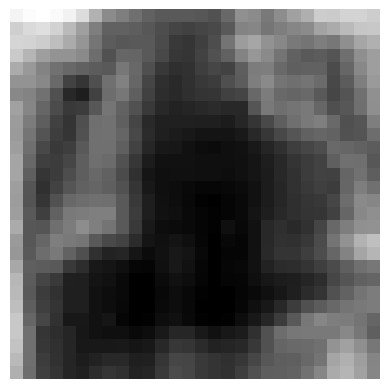

In [ ]:
plt.imshow(X[9], cmap='binary')
plt.axis('off')  # hide axes
plt.show() # shows an image taken from the dataset

# Perceptron

Eseguiamo la suddivisione in training test e testing set sia per le immagini X (appiattite) che per le etichette y.
Al testing set andrà il 20% del dataset, ed il seme casuale di partenza è 42.

## Training set and testing set

In [ ]:
from sklearn.model_selection import train_test_split
X_train_perc, X_test_perc, y_train_perc, y_test_perc = train_test_split(flattened_images, y, test_size = 0.2, random_state=42)

## Parameter optimization

Per l'ottimizzazione dei parametri viene usato il dizionario param_grid per definire due parametri da ottimizzare:

eta0: noto anche come tasso di apprendimento iniziale, controlla la dimensione degli aggiornamenti apportati ai pesi del Perceptron durante l'apprendimento. Valori più alti di eta0 portano ad aggiornamenti più grandi e ad un apprendimento più rapido, ma possono anche causare instabilità e oscillazioni. Valori più bassi di eta0 portano ad aggiornamenti più piccoli e ad un apprendimento più lento, ma possono anche migliorare la convergenza.

max_iter: Determina il numero massimo di iterazioni che l'algoritmo di apprendimento eseguirà. Un valore maggiore consente un apprendimento più approfondito, ma può aumentare il tempo di calcolo.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron

#Cration of a dictionary with parameter
param_grid = {
    'eta0': [0.01, 0.05, 0.1],
    'max_iter': [1000, 5000, 10000]
}

per_clf = Perceptron()

# Creation of an object GridSearchCV to search parameters
#per_clf: Perceptron object
#param_grid: dictionary with parameters to optimize.
#cv: Number of fold for the cross-validation. A higher value of cv provides a more robust estimate of performance, but increases computation time.
#scoring: Metric
grid_search = GridSearchCV(per_clf, param_grid, cv=10, scoring='accuracy')

# Parameter search using cross-validation, evaluating different combinations of values ​​for learning_rate and max_iter on the training data.
grid_search.fit(X_train_perc, y_train_perc.ravel())

# Print results
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

#Optimal parameters
best_params = grid_search.best_params_

Best parameters: {'eta0': 0.05, 'max_iter': 1000}
Best accuracy: 0.9359753799773898


## Execution

L'esecuzione del modello sul testing set avviene utilizzando i migliori parametri ottenuti nella fase precedente di ottimizzazione

In [ ]:
#We use best parameters in Perceptron
per_clf.eta0 = best_params['eta0']
per_clf.max_iter = best_params['max_iter']

per_clf.fit(X_train_perc, y_train_perc.ravel())

Perceptron(eta0=0.05)

## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predicitions on test set
y_pred_perc = per_clf.predict(X_test_perc)

# Calculate accuracy
accuracy = accuracy_score(y_test_perc, y_pred_perc)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
print(classification_report(y_test_perc, y_pred_perc))

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       265
           1       0.98      0.96      0.97       782

    accuracy                           0.95      1047
   macro avg       0.93      0.94      0.93      1047
weighted avg       0.95      0.95      0.95      1047



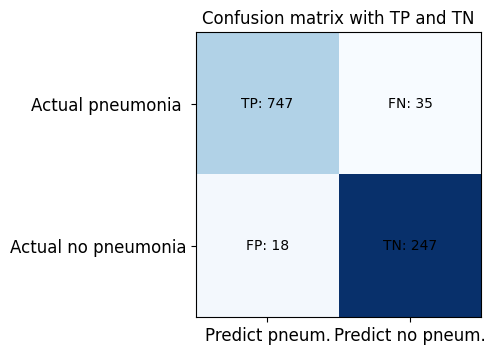

In [ ]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test_perc, y_pred_perc)

# Function to view confusion matrix with labels TP e TN
def plot_confusion_matrix_tp_tn(cm, title='Confusion matrix'):
    TN = cm[0, 0]  # True Negative
    TP = cm[1, 1]  # True Positive
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Add labels into cells
    for (i, j), z in np.ndenumerate(cm):
        if i == 0 and j == 0:
            ax.text(j, i, f"TP: {TP}", ha='center', va='center', fontsize=10)
        elif i == 1 and j == 0:
            ax.text(j, i, f"FP: {FP}", ha='center', va='center', fontsize=10)
        elif i == 0 and j == 1:
            ax.text(j, i, f"FN: {FN}", ha='center', va='center', fontsize=10)
        else:
            ax.text(j, i, f"TN: {TN}", ha='center', va='center', fontsize=10)

    plt.title(title)
    plt.xticks([0, 1], ['Predict pneum.', 'Predict no pneum.'])
    plt.yticks([0, 1], ['Actual pneumonia ', 'Actual no pneumonia'])
    plt.tight_layout()

# View confusion matrix with TP and TN
plot_confusion_matrix_tp_tn(cm, title='Confusion matrix with TP and TN')
plt.show()


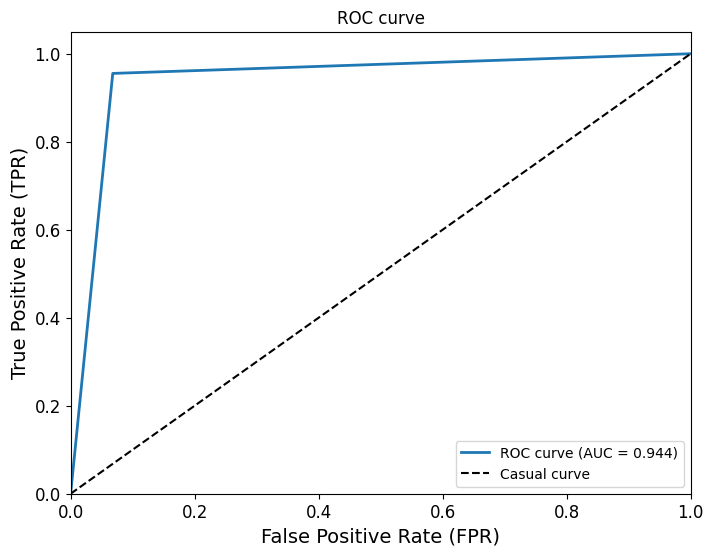

In [ ]:
from sklearn.metrics import roc_curve, auc
# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_test_perc, y_pred_perc)
roc_auc = auc(fpr, tpr)

# View ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Casual curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# Random Forest

## Training set and testing set

Eseguiamo la suddivisione in training test e testing set sia per le immagini X (appiattite) che per le etichette y. Al testing set andrà il 20% del dataset, ed il seme casuale di partenza è 42.

In [ ]:
from sklearn.model_selection import train_test_split
# creation of training set and testing set for X and Y. Random_state is used to generate the subdivision from the same seed
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(flattened_images, y, test_size=0.2, random_state=42)

## Parameter optimization

Per l'ottimizzazione di parametri viene creato un dizionario param_dist in cui vengono ottimizzati i seguenti parametri:

n_estimators: questo parametro specifica il numero di alberi decisionali da creare. Un valore più alto porta a una foresta più complessa e potenzialmente a migliori prestazioni, ma aumenta anche il tempo di training.

max_depth: questo parametro controlla la profondità massima consentita agli alberi decisionali. Un valore più alto permette alberi più complessi e specifici, ma aumenta il rischio di sovraccaricamento. None indica la profondità illimitata

min_samples_leaf: questo parametro stabilisce il numero minimo di campioni richiesti per creare un nodo foglia in un albero decisionale. Valori più alti portano ad alberi più conservativi e meno inclini al sovraccaricamento, ma potrebbero ridurre la flessibilità del modello.

min_samples_split: questo parametro determina il numero minimo di campioni necessari per dividere un nodo in due rami durante la creazione dell'albero. Valori più alti portano ad alberi più robusti, ma potrebbero ridurre la capacità del modello di catturare pattern complessi.

bootstrap: questo parametro attiva o disattiva il bootstrap aggregating (bagging). Se True, ad ogni albero decisionale viene fornito un sottoinsieme casuale con sostituzione dei dati di training, aumentando la diversità della foresta. Disabilitare il bagging (bootstrap=False) crea una foresta in cui ogni albero viene allenato sull'intero dataset.

class_weight: questo parametro permette di gestire le classi squilibrate, ovvero situazioni in cui alcune classi del dataset sono rappresentate da un numero di campioni significativamente maggiore rispetto ad altre.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Creation of RandomForest instance
rf_model = RandomForestClassifier()

# Dictionary that specifies the distribution of possible values ​​for each hyperparameter of the Random Forest model.
# n_estimators = number of decisional trees. The choice is between 100 and 500
# max_depth = maximum depth of every decisional tree. To find the best value to avoid overfitting we star from a small value (4) and and the value progressively increases up to 32
# min_samples_leaf, min_samples_split = These parameters control the minimum node size and granularity of tree splitting. Values between 2 and 10 are ok
# bootstrap = we attempt sampling with repeatition and without
# class_weght = we give more importance to the minority class during training.

param_dist = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [4, 8, 16, 32, None],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [2, 4, 8],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

# we use 10 iterations
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')

#Fit to select the combination of hyperparameters that produces the best evaluation metric (in this case, accuracy)
random_search.fit(X_train_rf, y_train_rf)

print("Best Hyperparamethers:", random_search.best_params_)
print("Best score:", random_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Best Hyperparamethers: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 32, 'class_weight': None, 'bootstrap': True}
Best score: 0.9471923536439665


## Execution

In [ ]:
# we applicate the best solution obtained with RandomizedSearchCV

best_n_estimators = random_search.best_params_['n_estimators']
best_max_depth = random_search.best_params_['max_depth']
best_min_samples_leaf = random_search.best_params_['min_samples_leaf']
best_min_samples_split = random_search.best_params_['min_samples_split']
best_bootstrap = random_search.best_params_['bootstrap']
best_class_weight = random_search.best_params_['class_weight']

best_rf_model = RandomForestClassifier(n_estimators=best_n_estimators, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, max_depth=best_max_depth, bootstrap=best_bootstrap, class_weight=best_class_weight)
best_rf_model.fit(X_train_rf, y_train_rf.ravel())

RandomForestClassifier(max_depth=32, min_samples_leaf=2, n_estimators=200)

## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Predicitions on test set
y_pred_rf = best_rf_model.predict(X_test_rf)

# Calculate accuracy
accuracy = accuracy_score(y_test_rf, y_pred_rf)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
print(classification_report(y_test_rf, y_pred_rf))

Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       265
           1       0.96      0.97      0.96       782

    accuracy                           0.95      1047
   macro avg       0.94      0.92      0.93      1047
weighted avg       0.95      0.95      0.95      1047



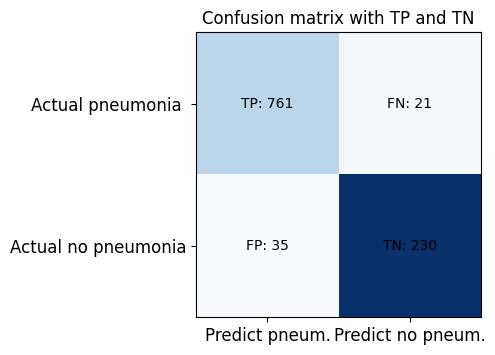

In [ ]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test_rf, y_pred_rf)

# Function to view confusion matrix with labels TP e TN
def plot_confusion_matrix_tp_tn(cm, title='Confusion matrix'):
    TN = cm[0, 0]  # True Negative
    TP = cm[1, 1]  # True Positive
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Add labels into cells
    for (i, j), z in np.ndenumerate(cm):
        if i == 0 and j == 0:
            ax.text(j, i, f"TP: {TP}", ha='center', va='center', fontsize=10)
        elif i == 1 and j == 0:
            ax.text(j, i, f"FP: {FP}", ha='center', va='center', fontsize=10)
        elif i == 0 and j == 1:
            ax.text(j, i, f"FN: {FN}", ha='center', va='center', fontsize=10)
        else:
            ax.text(j, i, f"TN: {TN}", ha='center', va='center', fontsize=10)

    plt.title(title)
    plt.xticks([0, 1], ['Predict pneum.', 'Predict no pneum.'])
    plt.yticks([0, 1], ['Actual pneumonia ', 'Actual no pneumonia'])
    plt.tight_layout()

# View confusion matrix with TP and TN
plot_confusion_matrix_tp_tn(cm, title='Confusion matrix with TP and TN')
plt.show()


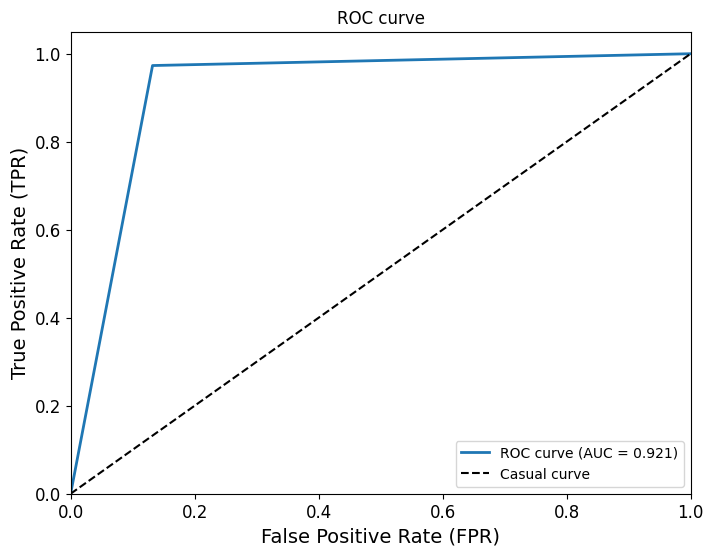

In [ ]:
from sklearn.metrics import roc_curve, auc
# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_test_rf, y_pred_rf)
roc_auc = auc(fpr, tpr)

# View ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Casual curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# Neural Network

## Training set, validation set and testing set

In questo caso viene eseguita una prima divisione tra training set (80%) e testing set (20%) e successivamente il training set viene diviso a sua volta in training set (80%) e validation set (20%)

In [ ]:
from sklearn.model_selection import train_test_split

# We divide datset in training e testing set (80% training, 20% per test)
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(flattened_images, y, test_size=0.2, random_state=42)

# We divide training set in training set and validation set (80% for training, 20% for validation)
X_train_final, X_valid_set, y_train_final, y_valid_set = train_test_split(X_train_set, y_train_set, test_size=0.2, random_state=42)

# Print dimension of every set
print("Training set dimension:", X_train_final.shape)
print("Y traning set dimension: ", y_train_final.shape)
print("Validation set dimension:", X_valid_set.shape)
print("Y validation set dimension: ", y_valid_set.shape)
print("Test set dimension:", X_test_set.shape)
print("Y testing set dimension: ", y_test_set.shape)

Training set dimension: (3348, 784)
Y traning set dimension:  (3348, 1)
Validation set dimension: (837, 784)
Y validation set dimension:  (837, 1)
Test set dimension: (1047, 784)
Y testing set dimension:  (1047, 1)


## Parameter optimization

In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.2 MB/s eta 0:00:00


Definiamo una funzione model_builder che viene utilizzata per creare e ottimizzare il modello.
Viene prima creato un modello sequenziale di Keras e poi si aggiungono i vari layer, tra cui il primo layer con 784 unità. Vediamo poi alcuni dettagli:

input_dim = X_train_final.shape[1]: specifica la dimensione dell'input (recuperata dalla forma del tensore di training X_train_final).

activation='relu': viene usata come funzione di attivazione la ReLU.

name='input_layer': viene assegnato un nome al layer per chiarezza.

kernel_initializer=hp.Choice('initializer', values=['glorot_normal', 'he_normal']): vengono provati due diversi inizializzatori per i pesi del layer (glorot_normal e he_normal).

Successivamente per gli hidden layer viene eseguito un ciclo per tentare di aggiungere un numero di layer nascosti definito da valori compresi tra 1 e 5.
In particolare vengono aggiunti layer densi in cui viene provare un numero di neuroni variabile tra 10 e 100 con incrementi di 10 per ogni layer nascosto.

activation="relu": specifica la funzione di attivazione ReLU.

name=f'hidden_layer_{i}': assegna un nome al layer che include l'indice i per distinguerli.

kernel_initializer=hp.Choice('initializer', values=['glorot_normal', 'he_normal']): come nel layer di input, viene usato KerasTuner per provare due diversi inizializzatori.

A questo punto si arriva al layer di output in cui viene aggiunto l'ultimo layer denso in cui si specifica un singolo neurone in uscita.

name='output_layer': assegna un nome al layer di output.

kernel_initializer=hp.Choice('initializer', values=['glorot_normal', 'he_normal']): usa KerasTuner per provare due diversi inizializzatori.

activation='sigmoid': specifica la funzione di attivazione sigmoid per l'uscita.
Inoltre si va a definire un ulteriore iperparametro, ossia
hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) che definisce l'iperparametro learning_rate che può assumere tre valori diversi (10^-2, 10^-3 e 10^-4).

Nella compilazione del modello viene usato l'ottimizzatore Adam con learning rate definito dall'iperparametro e la funzione di costo per la classificazione binaria e la binary_crossentropy. Come metrica di valutazione la scelta è ricaduta sull'accuratezza.

In [ ]:
import keras_tuner as kt

def model_builder(hp):
  # creation of a sequential model
  model = Sequential()

  model.add(
      Dense(units=784,
            input_dim = X_train_final.shape[1],
            activation='relu',
            name = 'input_layer',
            kernel_initializer=hp.Choice('initializer', values=['glorot_normal', 'he_normal'])
            )
      )

  #in this loop, we try to have a number of hidden layer between 1 and 5
  #We try to add a layer with a number of neurons between 10 and 100 in increments of 10
  for i in range(hp.Int("num_layers", 1, 5)):
    model.add(
        Dense(
        units=hp.Int(f"units_{i}", min_value=10, max_value=100, step=10),
                activation="relu",
                name = f'hidden_layer_{i}',
                kernel_initializer=hp.Choice('initializer', values=['glorot_normal','he_normal'])
          )
    )

  model.add(
      Dense(units=1,
            name = 'output_layer',
            kernel_initializer=hp.Choice('initializer', values=['glorot_normal', 'he_normal']),
            activation='sigmoid')
      )

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model


Successivamente, è interessante aggiungere l'utilizzo dell'early stopping. In particolare il training viene fermato se l'accuratezza non migliora dopo 10 epoche consecutive.

In [ ]:
tuner = kt.Hyperband(hypermodel = model_builder,
                     objective='val_accuracy',
                     max_epochs=100,
                     directory='/content/drive/My Drive/tuning',
                     project_name='Untitled1.ipynb'
                    )

#we stop the training if accuracy doesn't improve for 10 consecutive epochs
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

tuner.search(X_train_final, y_train_final, epochs=100, validation_data = (X_valid_set, y_valid_set), callbacks=[early_stopping])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 254 Complete [00h 00m 28s]
val_accuracy: 0.9510155320167542

Best val_accuracy So Far: 0.965352475643158
Total elapsed time: 00h 59m 37s


In [ ]:
from IPython.display import Markdown, display

units = []
for i in range(0, best_hps.get("num_layers")):
  units.append(best_hps.get(f"units_{i}"))

hyp_string = f"""
The hyperparameter search is complete.
* the optimal number of layers is {best_hps.get("num_layers")};
* the optimal number of units in each layer is: {' '.join(str(unit) for unit in units)};
* the optimal initializer is {best_hps.get("initializer")};
* the optimal number of epochs is {best_hps.get("tuner/epochs")};
* the optimal learning rate is {best_hps.get("learning_rate")};
* the optimal starting epoch is {best_hps.get("tuner/initial_epoch")};
"""

def printmd(string):
    display(Markdown(string))

printmd(hyp_string)


The hyperparameter search is complete.
* the optimal number of layers is 4;
* the optimal number of units in each layer is: 100 70 100 40;
* the optimal initializer is he_normal;
* the optimal number of epochs is 100;
* the optimal learning rate is 0.0001;
* the optimal starting epoch is 34;


## Execution

In [ ]:
model = tuner.hypermodel.build(best_hps)
model.summary()
model.fit(X_train_final, y_train_final, epochs=best_hps.get("tuner/epochs"), initial_epoch=best_hps.get("tuner/initial_epoch"), batch_size=32, validation_data = (X_valid_set, y_valid_set))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 784)               615440    
                                                                 
 hidden_layer_0 (Dense)      (None, 100)               78500     
                                                                 
 hidden_layer_1 (Dense)      (None, 70)                7070      
                                                                 
 hidden_layer_2 (Dense)      (None, 100)               7100      
                                                                 
 hidden_layer_3 (Dense)      (None, 40)                4040      
                                                                 
 output_layer (Dense)        (None, 1)                 41        
                                                                 
Total params: 712191 (2.72 MB)
Trainable params: 71219

## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import binarize


# Prediction for testing set
y_pred = model.predict(X_test_set)
# We use the threshold to obtain a value that is 0 or 1
y_pred_bin = binarize(y_pred, threshold=0.5)


# Compute accuracy
accuracy = accuracy_score(y_test_set, y_pred_bin)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
print(classification_report(y_test_set, y_pred_bin))

33/33 [==============================] - 0s 4ms/step
Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.81      0.97      0.89       265
           1       0.99      0.92      0.96       782

    accuracy                           0.94      1047
   macro avg       0.90      0.95      0.92      1047
weighted avg       0.95      0.94      0.94      1047



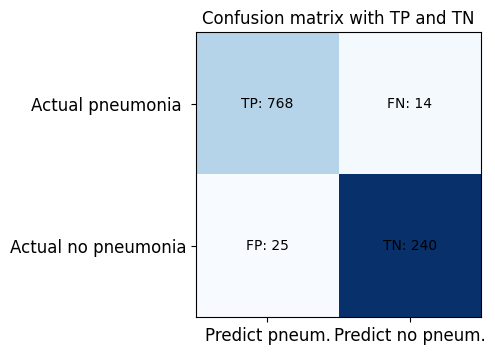

In [ ]:
from sklearn.metrics import confusion_matrix

# Genera la matrice di confusione
cm = confusion_matrix(y_test_set, y_pred_bin)

# Funzione per visualizzare la matrice di confusione con etichette TP e TN
def plot_confusion_matrix_tp_tn(cm, title='Matrice di Confusione'):
    TN = cm[0, 0]  # True Negative
    TP = cm[1, 1]  # True Positive
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Aggiungi etichette all'interno delle celle
    for (i, j), z in np.ndenumerate(cm):
        if i == 0 and j == 0:
            ax.text(j, i, f"TP: {TP}", ha='center', va='center', fontsize=10)
        elif i == 1 and j == 0:
            ax.text(j, i, f"FP: {FP}", ha='center', va='center', fontsize=10)
        elif i == 0 and j == 1:
            ax.text(j, i, f"FN: {FN}", ha='center', va='center', fontsize=10)
        else:
            ax.text(j, i, f"TN: {TN}", ha='center', va='center', fontsize=10)

    plt.title(title)
    plt.xticks([0, 1], ['Predict pneum.', 'Predict no pneum.'])
    plt.yticks([0, 1], ['Actual pneumonia ', 'Actual no pneumonia'])
    plt.tight_layout()

# View confusion Matrix with TP and TN
plot_confusion_matrix_tp_tn(cm, title='Confusion matrix with TP and TN')
plt.show()


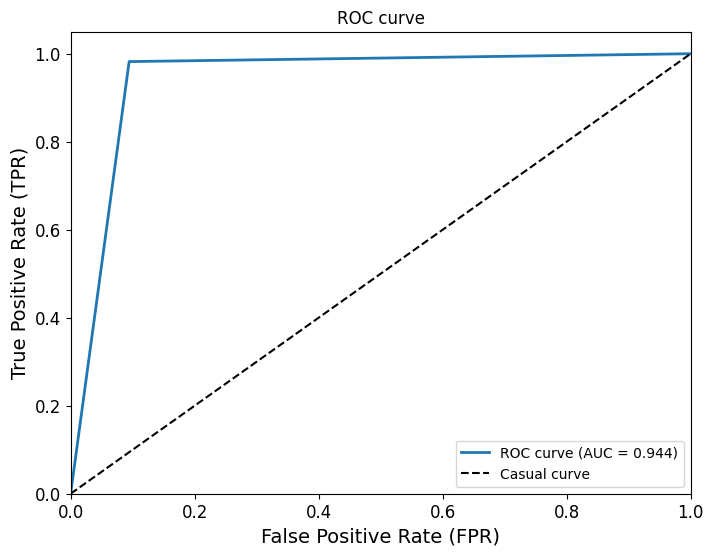

In [ ]:
# @title Testo del titolo predefinito
from sklearn.metrics import roc_curve, auc
# Calcola l'AUC
fpr, tpr, thresholds = roc_curve(y_test_set, y_pred_bin)
roc_auc = auc(fpr, tpr)

# Visualizza la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Casual curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# Logistic Regression

## Training and testing set

Eseguiamo la suddivisione in training test e testing set sia per le immagini X (appiattite) che per le etichette y. Al testing set andrà il 20% del dataset, ed il seme casuale di partenza è 42.

In [ ]:
from sklearn.model_selection import train_test_split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(flattened_images, y, test_size=0.2, random_state=42)

## Parameter optimization

Per fare ottimizzazione dei parametri viene usato un dizionario param_grid in cui troviamo i seguenti parametri:

'C': il parametro C controlla la forza della penalizzazione applicata ai coefficienti del modello per evitare il sovraccaricamento. Un valore di C elevato porta a coefficienti più piccoli e a un modello più semplice, mentre un valore di C basso permette coefficienti più grandi e un modello più complesso. In particolare, viene generato un array di 7 valori di C spaziati logaritmicamente tra 10^−3 e 10^3. L'utilizzo di una scala logaritmica è comune in quanto i valori ottimali di C possono variare su un ampio intervallo.

'penalty': Questa chiave specifica il tipo di regolarizzazione da utilizzare. La regressione logistica supporta due tipi comuni di regolarizzazione:la regolarizzazione L1, in cui si penalizza la somma dei valori assoluti dei coefficienti, favorendo soluzioni con un minor numero di coefficienti non nulli e selezionando quindi le variabili più importanti; la regolarizzazione L2, la quale penalizza la somma dei quadrati dei coefficienti, favorendo soluzioni con coefficienti più piccoli e distribuendo il peso in modo più uniforme tra le variabili.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Creation of dictionary with parameters
param_grid = {
    'C': np.logspace(-3,3,7),
    'penalty': ['l1','l2'],
}

# Specification of solver = liblinear because it is compatible with l1 and l2
lr_model = LogisticRegression(solver = 'liblinear')

# Creation of GridSearchCV object
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy')

# Start tuning of parameters
grid_search.fit(X_train_log, y_train_log.ravel())

# Best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Optimal parameters:", best_params)
print("Best accuracy:", best_score)

Optimal parameters: {'C': 10.0, 'penalty': 'l2'}
Best accuracy: 0.9574671445639188


## Execution

In [ ]:
#We use best parameters in Logistic Regression
lr_model.C = best_params['C']
lr_model.penalty = best_params['penalty']
lr_model.fit(X_train_log, y_train_log.ravel())

LogisticRegression(C=10.0, solver='liblinear')

## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

#Predictions on test set
y_pred_log = lr_model.predict(X_test_log)

# Calculate accuracy
accuracy = accuracy_score(y_test_log, y_pred_log)
print(f'Accuracy: {accuracy:.2f}')

# View classification report
print(classification_report(y_test_log, y_pred_log))

Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       265
           1       0.97      0.98      0.97       782

    accuracy                           0.96      1047
   macro avg       0.95      0.95      0.95      1047
weighted avg       0.96      0.96      0.96      1047



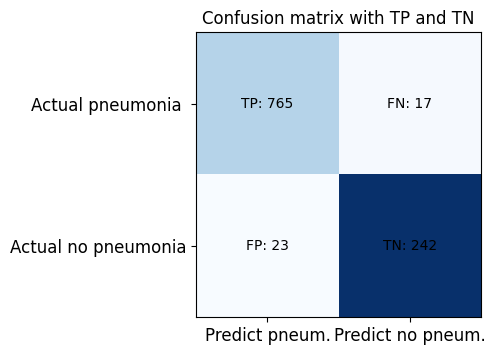

In [ ]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test_log, y_pred_log)

# Function to view confusion matrix with labels TP and TN
def plot_confusion_matrix_tp_tn(cm, title='Confusion Matrix'):
    TN = cm[0, 0]  # True Negative
    TP = cm[1, 1]  # True Positive
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(cm, interpolation='nearest', cmap='Blues')

    # Add labels into cells
    for (i, j), z in np.ndenumerate(cm):
        if i == 0 and j == 0:
            ax.text(j, i, f"TP: {TP}", ha='center', va='center', fontsize=10)
        elif i == 1 and j == 0:
            ax.text(j, i, f"FP: {FP}", ha='center', va='center', fontsize=10)
        elif i == 0 and j == 1:
            ax.text(j, i, f"FN: {FN}", ha='center', va='center', fontsize=10)
        else:
            ax.text(j, i, f"TN: {TN}", ha='center', va='center', fontsize=10)

    plt.title(title)
    plt.xticks([0, 1], ['Predict pneum.', 'Predict no pneum.'])
    plt.yticks([0, 1], ['Actual pneumonia ', 'Actual no pneumonia'])
    plt.tight_layout()

# View confusion matrix with TP and TN
plot_confusion_matrix_tp_tn(cm, title='Confusion matrix with TP and TN')
plt.show()


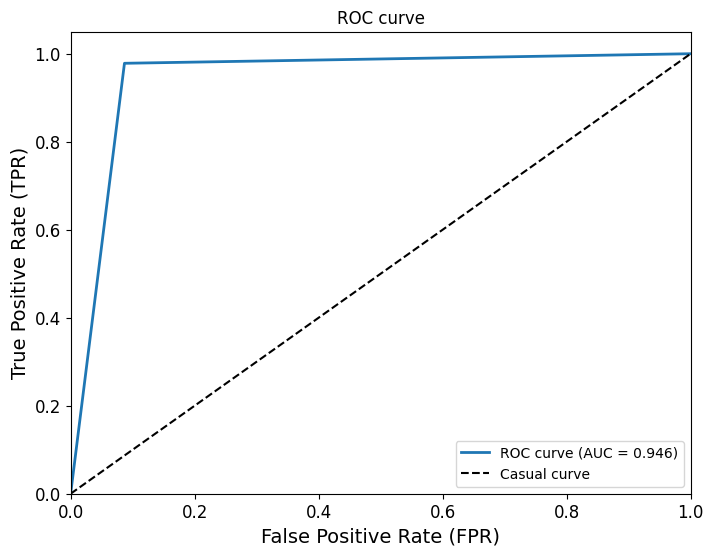

In [ ]:
from sklearn.metrics import roc_curve, auc
# Calculate AUC
fpr, tpr, thresholds = roc_curve(y_test_log, y_pred_log)
roc_auc = auc(fpr, tpr)

# View ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Casual curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

# Results

In [ ]:
import plotly.graph_objects as go

values = [['Best accuracy', 'Best precision', 'Best recall', 'Best f1-score'], #1st col
  [0.96, 0.99, 0.98, 0.97], ["Logistic Regression", "Neural Network", "Logistic Regression", "Logistic Regression"]]


fig = go.Figure(data=[go.Table(
  columnorder = [1,2,3],
  columnwidth = [150,300,300],
  header = dict(
    values = [['<b>METRICS</b>'],
                  ['<b>BEST VALUES</b>'],
              ['<b>MODEL</b>']],
    line_color='darkslategray',
    fill_color='royalblue',
    align=['left','center'],
    font=dict(color='white', size=12),
    height=40
  ),
  cells=dict(
    values=values,
    line_color='darkslategray',
    fill=dict(color=['paleturquoise', 'white']),
    align=['left', 'center'],
    font_size=12,
    height=30)
    )
])
fig.show()